In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import glob
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import tensorflow as tf
import keras
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import gzip
import sys

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

***
# LCC data import

In [2]:
# Import lcc data files for wt protein and assign to variable (wt_windowsize)

wt_files=glob.glob('w*.lccdata')

window_range = list(range(2,51))
wt_dict = {}
for window, file in zip(window_range, wt_files):
    wt_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0) 

In [3]:
# Import lcc data files for mutant protein and assign to variable (mutant_windowsize)

m_files=glob.glob('m*.lccdata')

D132H_dict = {}
for window, file in zip(window_range, m_files):
    D132H_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0)

In [4]:
# Visualization of dataset

print('WT for window size = 5')
display(wt_dict[5])

print('\n')
print('---------------------------------')
print('D132H for window size = 12')
display(D132H_dict[12])

WT for window size = 5


,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,8.4312,9.5361,9.3766,9.2660,9.9433,9.4571,9.6182,10.2676,10.2226,9.7319,...,8.8330,9.4795,13.4022,11.3185,12.1872,12.1484,15.8102,16.4597,15.1450,12.9981
1,8.7916,9.6580,9.6946,9.7889,10.2710,8.7514,9.1729,9.4072,9.8066,9.5092,...,8.7344,9.5236,13.5687,11.1643,12.8380,12.0473,16.2331,17.3571,14.5102,10.3342
2,8.4969,9.7424,9.2856,9.4945,10.2100,9.7501,9.3951,9.3884,9.2633,9.3148,...,11.0931,10.2994,15.4896,10.8769,12.1511,13.8864,10.9804,11.2729,13.8106,10.6559
3,8.3818,10.0616,8.6280,9.6703,10.6699,9.0544,9.7888,10.8737,9.1554,10.2863,...,12.8534,11.7250,16.3966,10.8761,11.9600,9.8509,17.0140,16.5833,14.3633,12.7481
4,7.5196,7.7193,10.1350,9.2006,9.3490,9.1282,9.3450,9.3715,9.5052,10.1185,...,9.0316,12.5238,14.8338,11.1429,12.7329,11.8138,17.1041,15.7779,11.8769,9.4603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,12.8071,14.6277,7.8362,11.2315,10.1866,11.3139,11.8900,11.4303,9.2643,9.5495,...,9.1574,10.5208,9.0648,9.1158,9.0196,9.3991,14.0049,12.2617,12.5114,13.8528
39996,14.6709,14.2225,10.0495,11.3026,10.3176,9.8255,11.8256,14.3835,10.5740,9.4388,...,8.6335,10.1313,10.4076,9.1010,8.7447,12.2108,10.6059,13.9447,14.4282,15.6855
39997,7.7636,12.9550,9.6664,9.1188,9.8602,8.4767,12.6994,13.0659,10.3564,8.5447,...,10.1644,10.8862,10.3117,9.7149,8.5182,10.5723,11.2149,12.8444,14.7079,16.1765
39998,12.8168,13.4219,5.3329,9.3870,9.7755,8.4664,9.9262,12.2373,10.5754,9.1512,...,8.6294,9.0778,11.2838,9.2821,8.2358,9.5664,10.0230,14.7938,15.0607,13.7237




---------------------------------
D132H for window size = 12


,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,17.2544,18.5460,20.2335,17.5743,18.2516,14.9958,14.0890,19.2429,11.3637,10.5668,...,21.9454,17.3618,20.1741,18.5240,21.6507,26.4761,25.3541,21.5266,28.3691,31.9909
1,18.0184,18.1145,19.7908,18.5282,18.4543,15.0499,14.6610,20.4204,13.9534,13.5068,...,19.6793,18.4111,21.3406,18.3380,19.9538,26.1776,25.5083,25.5529,29.0048,28.9661
2,18.6480,19.5519,21.1536,19.6276,19.3310,16.5011,15.5453,20.3391,15.6460,14.0567,...,19.9914,15.5205,17.6850,18.3114,25.2819,22.8756,23.5028,24.4405,27.1894,26.7587
3,17.3058,19.4245,20.3042,18.7338,17.7941,13.6412,13.2863,19.6351,13.9899,14.3771,...,22.3635,22.2206,25.1627,21.0134,24.4350,25.1088,24.5927,26.2216,27.2357,26.8857
4,17.4371,20.2468,21.4620,18.6958,17.7962,16.5941,18.0874,21.9220,13.5241,14.8083,...,18.6782,23.2148,22.5731,19.6743,23.8261,24.6477,24.9682,26.4675,27.2646,27.3087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,20.1262,16.4970,18.7419,18.4391,17.9316,13.3469,6.2733,8.1230,15.3153,12.2602,...,17.7812,19.3003,18.7916,18.3789,18.5789,14.3787,17.7950,11.1164,11.1604,20.3502
39996,18.4461,18.8259,22.7662,22.0188,18.8853,13.3072,6.2535,9.5151,16.5346,11.7140,...,18.4096,20.6778,18.8001,18.3584,17.8929,12.8377,17.5137,11.2960,11.5528,20.8567
39997,20.3085,19.1779,18.9030,18.9518,18.6252,13.4729,6.2951,8.3997,15.3879,11.6195,...,19.4887,19.6447,20.9796,19.1305,18.6703,13.2119,16.3622,10.9929,10.7441,19.3623
39998,21.0826,17.0348,17.7007,18.8354,17.9297,12.8318,5.9919,9.1569,14.9421,11.0831,...,17.7948,20.4257,20.7421,17.5806,19.8371,13.7586,17.4126,11.0054,10.8174,19.8463


***
# 1.2 MLP classifier + weights extraction

In [80]:
# Data pre processing

def preprocessing(wt, mutant):
    
    wt_label = np.zeros(len(wt)) # Set wt labels to 0
    
    mutant_label = np.ones(len(mutant))
    
    # Concatenate data frames and label arrays

    X_train_full = pd.concat([wt.reset_index(), mutant.reset_index()])
    y_train_full = np.concatenate((wt_label, mutant_label))
            
    #Drop index column and normalise training data
    X_train_full = X_train_full.drop(columns = 'index')
    
    X_train_full= X_train_full.div(100)
    
    # Separate training and validation sets and print relevant shapes
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.2)
    
    print('Window size:', str(window))
    print(X_train.shape)
    print(X_valid.shape)
    print(y_train.shape)
    print(y_valid.shape)
    
    return X_train, X_valid, y_train, y_valid

In [83]:
X_train_12, X_valid_12, y_train_12, y_valid_12 = preprocessing(wt_12, D132H_12)

Window size: 50
(64000, 58)
(16000, 58)
(64000,)
(16000,)


In [85]:
X_train_12

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
29474,0.099188,0.102695,0.191187,0.171863,0.190560,0.173311,0.088897,0.131773,0.166836,0.087143,...,0.194263,0.219580,0.220661,0.190087,0.187621,0.203705,0.217938,0.212876,0.214799,0.170713
4528,0.183496,0.186323,0.204198,0.136381,0.138165,0.120824,0.101212,0.169432,0.193642,0.138622,...,0.176442,0.195617,0.210675,0.224433,0.252155,0.220815,0.180085,0.230455,0.303950,0.244979
22902,0.214893,0.172436,0.194774,0.151531,0.139647,0.107298,0.069464,0.156774,0.188859,0.153818,...,0.194088,0.208982,0.181712,0.181173,0.179903,0.200555,0.160800,0.192398,0.181949,0.113818
21762,0.192556,0.206708,0.165186,0.174097,0.172450,0.170690,0.171560,0.140543,0.150564,0.088146,...,0.127754,0.164475,0.196765,0.202237,0.204350,0.196622,0.181892,0.156593,0.131332,0.166934
13458,0.193088,0.195340,0.159170,0.144060,0.164271,0.152135,0.123924,0.173020,0.134199,0.067379,...,0.240338,0.214465,0.204084,0.215401,0.252182,0.245931,0.211427,0.217883,0.232884,0.238102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26525,0.183486,0.173811,0.188015,0.229620,0.199560,0.129958,0.109543,0.103935,0.130167,0.063703,...,0.205592,0.198164,0.181919,0.185729,0.215209,0.230549,0.242142,0.215511,0.270730,0.253157
29716,0.190304,0.234571,0.219409,0.198380,0.166620,0.147857,0.075514,0.113689,0.146921,0.104708,...,0.058235,0.144170,0.114605,0.102908,0.172408,0.207342,0.184041,0.188669,0.200899,0.194861
9998,0.284005,0.272475,0.247916,0.220666,0.190629,0.147813,0.068965,0.130272,0.103531,0.056841,...,0.184662,0.241674,0.188380,0.177674,0.230919,0.231768,0.211334,0.216192,0.220234,0.227178
37665,0.248336,0.197329,0.134378,0.111397,0.126608,0.120479,0.052938,0.088077,0.160684,0.134280,...,0.195763,0.207831,0.219676,0.227516,0.224392,0.168180,0.136162,0.048760,0.091446,0.135667


In [169]:
# Builds multilayer perceptron classifier

def get_MLP(train_data):
       
    #Input layer
    input_layer = Input(shape=(train_data.shape[1]), name='mlp_input')
    
    dense_1 = Dense(128, activation='relu', name='dense_1')(input_layer)
    dense_2 = Dense(64, activation='relu', name='dense_2')(dense_1)
    dense_3 = Dense(32, activation='relu', name='dense_3')(dense_2)

    output_layer = Dense(1, activation='sigmoid', name='mlp_output')(dense_3)
    
    model = Model(input_layer, output_layer)

    return model   

In [170]:
mlp = get_MLP(X_train_12)

In [171]:
mlp.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mlp_input (InputLayer)      [(None, 58)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               7552      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 mlp_output (Dense)          (None, 1)                 33        
                                                                 
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [95]:
mlp.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [96]:
# Define callbacks
checkpoint_cb = ModelCheckpoint('mlp_model.h5', save_best_only = True)
early_stopping_cb = EarlyStopping(patience=50, restore_best_weights = True)

In [98]:
# Train MLP model with early stopping
history = mlp.fit(X_train_12, y_train_12, epochs = 1000, 
                  validation_data = (X_valid_12, y_valid_12),
                  callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4331 - accuracy: 0.7910 - val_loss: 0.3564 - val_accuracy: 0.8320
Epoch 2/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3233 - accuracy: 0.8526 - val_loss: 0.2990 - val_accuracy: 0.8618
Epoch 3/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2721 - accuracy: 0.8771 - val_loss: 0.2533 - val_accuracy: 0.8867
Epoch 4/1000
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2343 - accuracy: 0.8963 - val_loss: 0.2339 - val_accuracy: 0.8981
Epoch 5/1000
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2105 - accuracy: 0.9078 - val_loss: 0.2123 - val_accuracy: 0.9080
Epoch 6/1000
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1918 - accuracy: 0.9175 - val_loss: 0.1922 - val_accuracy: 0.9251
Epoch 7/1000
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1758 - accuracy: 0.9255 - val_loss: 0.1879 -

Epoch 57/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0324 - accuracy: 0.9879 - val_loss: 0.0485 - val_accuracy: 0.9819
Epoch 58/1000
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0308 - accuracy: 0.9888 - val_loss: 0.0659 - val_accuracy: 0.9764
Epoch 59/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0319 - accuracy: 0.9877 - val_loss: 0.0391 - val_accuracy: 0.9861
Epoch 60/1000
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0281 - accuracy: 0.9896 - val_loss: 0.0587 - val_accuracy: 0.9783
Epoch 61/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0328 - accuracy: 0.9880 - val_loss: 0.0454 - val_accuracy: 0.9844
Epoch 62/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0293 - accuracy: 0.9892 - val_loss: 0.0624 - val_accuracy: 0.9776
Epoch 63/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0

2000/2000 [==============================] - 3s 1ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0424 - val_accuracy: 0.9887
Epoch 168/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0826 - val_accuracy: 0.9789
Epoch 169/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0119 - accuracy: 0.9957 - val_loss: 0.0307 - val_accuracy: 0.9913
Epoch 170/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0467 - val_accuracy: 0.9871
Epoch 171/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0296 - val_accuracy: 0.9919
Epoch 172/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0091 - accuracy: 0.9967 - val_loss: 0.0482 - val_accuracy: 0.9874
Epoch 173/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 0.0603 - 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0250 - val_accuracy: 0.9932
Epoch 278/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0314 - val_accuracy: 0.9912
Epoch 279/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0401 - val_accuracy: 0.9901
Epoch 280/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.0744 - val_accuracy: 0.9791
Epoch 281/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.0425 - val_accuracy: 0.9885
Epoch 282/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0244 - val_accuracy: 0.9940
Epoch 283/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.0288 - 

<function matplotlib.pyplot.show(close=None, block=None)>

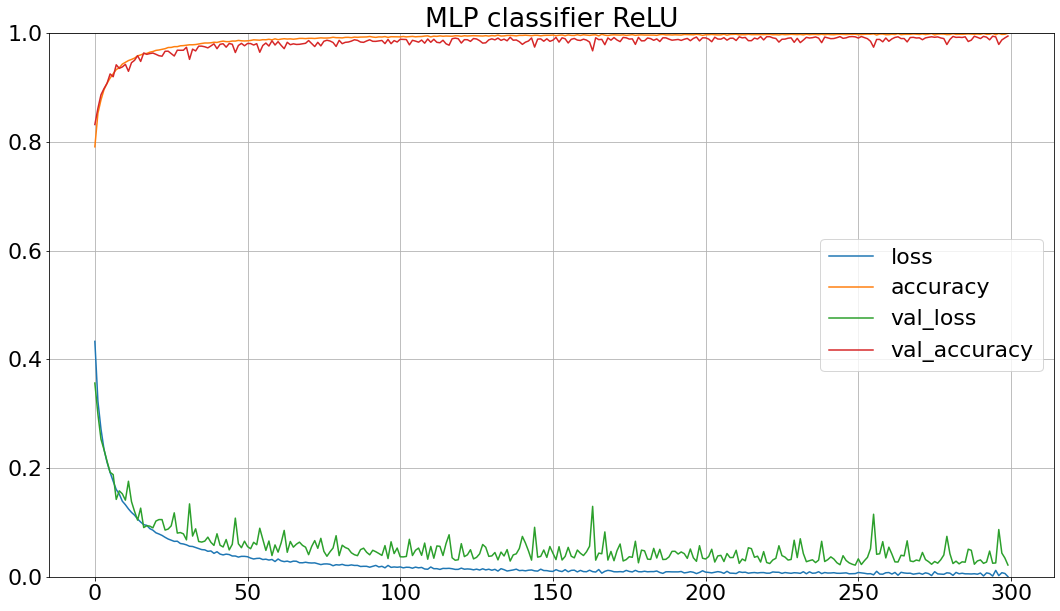

In [99]:
# Plot MLP training history
pd.DataFrame(history.history).plot(figsize=(18,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plot_name = 'MLP classifier ReLU'
plt.title(plot_name) 
figure_name = 'MLP classifier ReLU_1.png'
plt.savefig(figure_name, dpi = 300)
plt.show

In [117]:
# Extract weights and convert to dataframe
weights_a = mlp.get_weights()[0]
weights_a_df = pd.DataFrame(weights_a)
weights_a_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.941891,-0.332785,-0.380181,-0.161726,0.093572,-0.091188,-0.027025,-0.093234,0.094501,0.078004,...,-0.048410,-0.407399,-0.007904,-0.134514,1.266761,-0.211009,0.097835,0.011435,0.104029,0.618513
1,0.186346,0.409470,-0.556318,0.110940,0.338781,0.086017,0.040774,0.092225,-0.005471,-0.055704,...,-0.105159,0.529077,0.140861,0.065037,0.193921,0.531630,0.051547,0.219353,-0.022343,-1.384974
2,0.034333,-0.503274,-0.570901,0.154301,0.491787,0.120238,-0.139630,-0.076457,0.155675,0.041376,...,0.059307,0.209386,-0.102708,0.089020,-0.182791,-0.522034,1.133224,-0.094452,0.172365,0.015244
3,0.068591,-1.146538,-0.660802,-0.168484,-0.541519,-0.076547,0.050042,-0.005650,-0.097065,-0.005980,...,-0.162401,-0.212692,0.167899,-0.067227,-0.107692,0.468915,1.089838,-0.078862,-0.147666,0.696638
4,-0.003342,-1.277744,-1.223827,-0.096978,-0.321145,-0.251374,-0.175382,-0.196887,-0.110788,0.083916,...,-0.006719,0.603625,0.176730,0.093043,0.440306,-0.517735,1.057763,-0.186973,-0.133580,1.552272
5,-0.153553,0.347605,0.548228,-0.179641,-0.445595,0.112355,-0.181537,-0.187195,0.169915,-0.077576,...,0.081326,0.509390,-0.048312,0.127132,-0.471646,1.183862,-0.411469,-0.069415,-0.060652,0.415145
6,-0.861448,0.123142,-0.062926,-0.194274,-0.584160,-0.078444,-0.083276,0.145991,-0.131417,-0.156503,...,-0.131538,-0.190196,-0.144940,0.110667,-0.088828,0.086550,-2.739538,0.184848,-0.162025,-0.082812
7,-0.373620,-0.258656,1.163150,-0.097779,-0.079636,0.212093,0.142555,-0.077531,-0.047542,-0.179744,...,-0.038055,-0.328527,-0.130478,0.114096,-0.049992,0.824448,-2.797992,-0.090296,0.027216,-1.336419
8,0.236056,-2.651214,-0.934259,0.025332,0.210801,-0.137231,0.104498,0.032609,-0.023675,0.154524,...,-0.003663,-1.691199,-0.133633,-0.072928,-1.044607,-1.387870,-2.240630,-0.172577,-0.035055,1.414504
9,0.264876,0.586347,-0.222995,-0.061959,0.859872,0.094315,-0.079318,-0.130370,-0.175184,-0.023179,...,-0.141425,-4.766634,-0.177133,0.048915,-0.036893,0.934827,0.126170,-0.019880,-0.149787,1.028249


<AxesSubplot:>

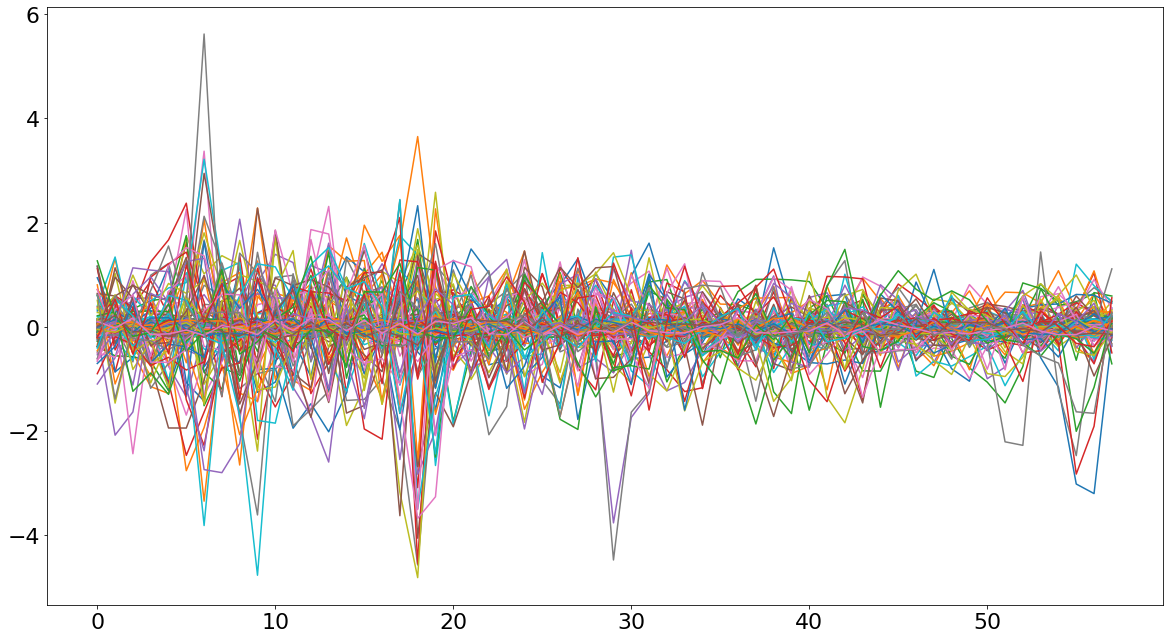

In [120]:
# Plots weights of best model
weights_a_df.plot(use_index=True, legend = False)

In [121]:
# Absolute values for weights
weights_a_df_abs = weights_a_df.abs()

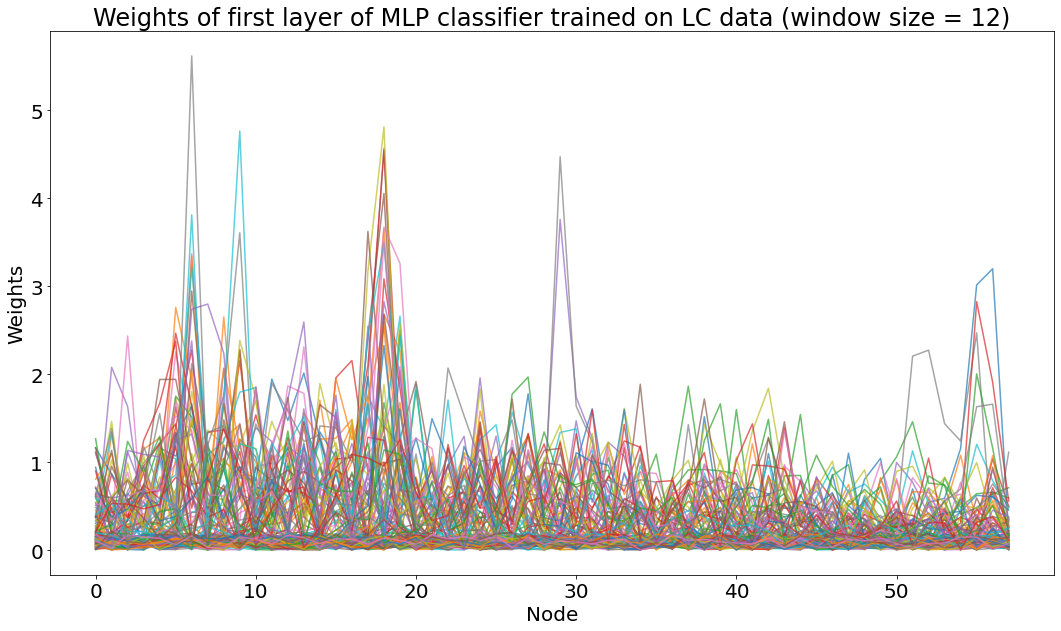

In [153]:
plt.rcParams['font.size'] = '20'
# Plots absolute values dataframe
weights_a_df_abs.plot(use_index=True, legend = False, alpha = 0.7, title = 'Weights of first layer of MLP classifier trained on LC data (window size = 12)', xlabel = 'Node', ylabel = 'Weights', figsize = (18,10)).get_figure().savefig('MLP_weights_ws12_e300_2.png', dpi=300)